<a href="https://colab.research.google.com/github/s1250103/Public_mori-lab/blob/preprcing-learning/experiments/preprcing-learning/learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# [スクラッチ]

In [ ]:
keras.backend.clear_session()
gc.collect()

# [環境構築]

In [10]:
import os
import shutil

import numpy as np

import tensorflow as tf
from tensorflow.keras.utils import plot_model
from tensorflow.keras import layers, models, initializers, callbacks

import keras
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout
from keras.utils.np_utils import to_categorical

import gc
from google.colab import drive

In [3]:
#@title gdrive マウント
if not os.path.exists('/content/drive'):
  drive.mount('/content/drive')
else:
  print("Already confirm")


Mounted at /content/drive


In [4]:
#@title 一時的にファイルを置くディレクトリ'desk'を作成
desk = '/content/desk'
if not os.path.exists(desk):
  os.mkdir(desk)
os.chdir(desk)

In [5]:
#@title 必要なファイルを'desk'にコピー
%%time
wants_paths = [
'/content/drive/MyDrive/colab/dence1223/key20201218.h5',
'/content/drive/MyDrive/colab/dence1223/normalTrainLabels.npz',
'/content/drive/MyDrive/colab/dence1223/normalTrainVideos.npz',
'/content/drive/MyDrive/colab/dence1223/normalTestLabels.npz',
'/content/drive/MyDrive/colab/dence1223/normalTestVideos.npz'
]

for want in wants_paths:
  if not os.path.exists(os.path.join(desk, os.path.basename(want))):
    shutil.copy2(want, desk)
    print("get : ", want)
            

get :  /content/drive/MyDrive/colab/dence1223/key20201218.h5
get :  /content/drive/MyDrive/colab/dence1223/normalTrainLabels.npz
get :  /content/drive/MyDrive/colab/dence1223/normalTrainVideos.npz
get :  /content/drive/MyDrive/colab/dence1223/normalTestLabels.npz
get :  /content/drive/MyDrive/colab/dence1223/normalTestVideos.npz
CPU times: user 606 ms, sys: 1.79 s, total: 2.4 s
Wall time: 53.9 s


In [6]:
#@title データフォーマットを規定
class video_format:
  name = "video_format"
  # サンプリングされたCMデータの仕様
  playtime = "15秒"
  displaysize = "(any, any, RGB)"
  videoformat = "any"
  # モデルが扱うCMデータ(上のようなデータは、下のように変換される)
  HEIGHT = 45
  WIDTH = 80
  FRAME_SIZE = 30
  COLOR = "RGB"
  FPS = "2 (FRAME_SIZE / playtime)" # 定義ではなく上から導かれた値

# [データ用意・学習準備]

In [7]:
format1 = video_format()
colorSet = {'BW' : 1, 'RGB' : 3}

def prepare_data():
  # traindata
  v = np.load('/content/desk/normalTrainVideos.npz')
  l = np.load('/content/desk/normalTrainLabels.npz')

  train_videos = [] 
  train_labels = []
  for i in v.files:
    train_videos.append(v[i])
  for i in l.files:
    train_labels.append(l[i])

  train_videos = np.array(train_videos)
  train_labels = np.array(train_labels)
  train_labels = tf.keras.utils.to_categorical(train_labels, 4)

  # testdata
  v = np.load('/content/desk/normalTestVideos.npz')
  l = np.load('/content/desk/normalTestLabels.npz')

  test_videos = []
  test_labels = []
  for i in v.files:
    test_videos.append(v[i])
  for i in l.files:
    test_labels.append(l[i])

  test_videos = np.array(test_videos)
  test_labels = np.array(test_labels)
  test_labels = tf.keras.utils.to_categorical(test_labels, 4)

  x_train = train_videos
  y_train = train_labels
  x_test = test_videos
  y_test = test_labels

  return x_train, y_train, x_test, y_test

In [11]:
x_train, y_train, x_test, y_test = prepare_data()

プロット

In [13]:
from pandas import DataFrame
import matplotlib.pyplot as plt
import os

def plot(history):
  HEIGHT = 2
  WIDTH = 2

  # 下地の用意
  fig = plt.figure()
  LOSS = fig.add_subplot(HEIGHT, WIDTH, 1)
  ACC = fig.add_subplot(HEIGHT, WIDTH, 2)
  LOSSDIF = fig.add_subplot(HEIGHT, WIDTH, 3)
  plt.subplots_adjust(left=None, bottom=None, right=1.5, top=1.5, wspace=None, hspace=None)

  # 1,1 loss
  loss = DataFrame(history.history['loss'])
  val_loss = DataFrame(history.history['val_loss'])
  loss_props = {
        'title' : 'LOSS',
        'xlabel' : 'epoch',
        'ylabel' : 'value'
    }
  LOSS.set(**loss_props)
  LOSS.plot(loss, label='loss', marker='o', color='blue')
  LOSS.plot(val_loss, label='val_loss', marker='o', linestyle='--', color='orange')

  # 1,2 acc
  acc = DataFrame(history.history['acc'])
  val_acc = DataFrame(history.history['val_acc'])
  acc_props = {
        'title' : 'ACCURACY',
        'xlabel' : 'epoch',
        'ylabel' : 'value'
    }
  ACC.set(**acc_props)
  ACC.plot(acc, label='acc', marker='o', color='blue')
  ACC.plot(val_acc, label='val_acc', marker='o', linestyle='--', color='orange')

  #2,1 loss.diff
  LOSSDIF.plot(loss.diff())
  LOSSDIF.plot(val_loss.diff())

  
  

  #save
  name = 'tmp'
  path_image = os.path.join(desk, name)
  fig.savefig(path_image)


一覧

In [14]:
# loss一覧
mse = tf.keras.losses.MeanSquaredError()
cce = tf.keras.losses.CategoricalCrossentropy()

# optimizer一覧
sgd = keras.optimizers.SGD(lr=0.00001, momentum=0.0, decay=0.0, nesterov=False)

# [[学習実行]]

In [ ]:
optimizer = keras.optimizers.SGD(lr=lr, momentum=0.0, decay=0.0, nesterov=False),

In [20]:
optimizer = keras.optimizers.Adam(
                                                    lr=1e-5, 
                                                    beta_1=0.9, 
                                                    beta_2=0.999, 
                                                    epsilon=None, 
                                                    decay=0.0, 
                                                    amsgrad=False)

Epoch 1/512
9/9 [==============================] - 1s 90ms/step - loss: 7.1361 - acc: 0.2736 - categorical_crossentropy: 7.3315 - val_loss: 7.3714 - val_acc: 0.2984 - val_categorical_crossentropy: 7.2312
Epoch 2/512
9/9 [==============================] - 1s 69ms/step - loss: 5.2564 - acc: 0.3177 - categorical_crossentropy: 5.1617 - val_loss: 3.4408 - val_acc: 0.2258 - val_categorical_crossentropy: 3.4129
Epoch 3/512
9/9 [==============================] - 1s 67ms/step - loss: 2.2250 - acc: 0.5315 - categorical_crossentropy: 2.2013 - val_loss: 2.9879 - val_acc: 0.2581 - val_categorical_crossentropy: 3.0160
Epoch 4/512
9/9 [==============================] - 1s 69ms/step - loss: 1.8819 - acc: 0.4415 - categorical_crossentropy: 1.8713 - val_loss: 1.4920 - val_acc: 0.2984 - val_categorical_crossentropy: 1.4799
Epoch 5/512
9/9 [==============================] - 1s 69ms/step - loss: 1.1211 - acc: 0.5748 - categorical_crossentropy: 1.1021 - val_loss: 1.7230 - val_acc: 0.4516 - val_categorical_c

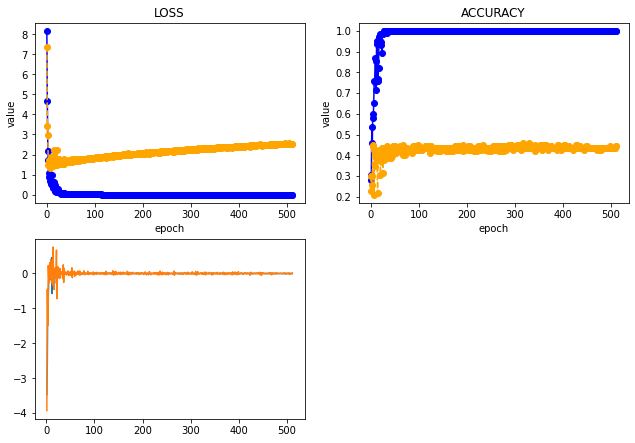

In [24]:
#学習設定
%%time
loss=cce

# モデル準備
model = models.load_model('/content/desk/key20201218.h5')

# コンパイル
model.compile(
    optimizer=optimizer,
    loss=tf.keras.losses.CategoricalCrossentropy(),
    metrics=['acc', cce])

# 実行
history = model.fit(
      x_train,
      y_train, 
      validation_data=(x_test, y_test),
      batch_size=16,
      epochs=512,
      # verbose=0
      )
print("Complete.")

# プロット
plot(history)

#[ストレージへ保存]

In [ ]:
shelf = '/content/drive/MyDrive/colab'
book = 'dence1223'
shelf_book = os.path.join(shelf, book)
if not os.path.exists(shelf_book):
  os.mkdir(shelf_book)   

In [ ]:
wants_paths = [
'/content/desk/normalTestLabels.npz',
'/content/desk/normalTestVideos.npz'
]    

for want in wants_paths:
  shutil.copy2(
      want,
      shelf_book
  )

#[掃き溜め]

In [ ]:
%tensorflow_version 2.x
!pip2 install --upgrade google-auth-oauthlib grpcio >/dev/null 2>&1
import shutil
from tensorflow.keras import layers, models, initializers, callbacks
log_dir = '/tmp/log'
shutil.rmtree(log_dir, ignore_errors=True)
tensorboard_callback = callbacks.TensorBoard(log_dir=log_dir,
                                             histogram_freq=1)

In [ ]:
losses = {
    'CCE' : 'categorical_crossentropy',
    'SCE' : 'sparse_categorical_crossentropy',

    'MSE' : 'mean_squared_error',
    'MSLE' : 'mean_squared_logarithmic_error',
    'MAE' : 'mean_absolute_error',
}
def inverse_dict(d):
    return {v:k for k,v in d.items()}

inv_losses = inverse_dict(losses)


In [ ]:
#@title 学習
%%time
history = model.fit(
      train_videos, train_labels, 
      validation_data=(test_videos, test_labels),
      batch_size=16, epochs= 30,
      # callbacks=[tensorboard_callback]
      )
print("Complete.")

In [ ]:
!curl -OL https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip
!unzip -o ngrok-stable-linux-amd64.zip

In [ ]:
get_ipython().system_raw(
    'tensorboard --logdir {} --host 0.0.0.0 --port 6006 &'
    .format(log_dir)
)
get_ipython().system_raw('./ngrok http 6006 &')
!curl -s http://localhost:4040/api/tunnels | python3 -c \
    "import sys, json; print(json.load(sys.stdin)['tunnels'][0]['public_url'])"

https://6b5d01d27e35.ngrok.io
